In [1]:
# Run this cell only once
import os
import sys
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D

sys.path.append('../')
print(os.getcwd())

/Users/nikhilthota/Desktop/lab/projects/SPIRAL/codes and datasets/Seq-AE/code/utils


In [2]:
def load_csv_file(file, skip_header):
    '''Load data from a text file, with missing values handled as specified.'''
    return np.genfromtxt(file, comments='#', delimiter=',', skip_header=skip_header)

### 2D latent space of NestedAE colored based on predicted bandgap, PCE, ETM and HTM.

/Users/nikhilthota/Desktop/lab/projects/SPIRAL/codes and datasets/Seq-AE/code/utils
 --> Loaded ETM predictions from csv.
 --> Loaded HTM predictions from csv.
 --> Loaded latents from csv.


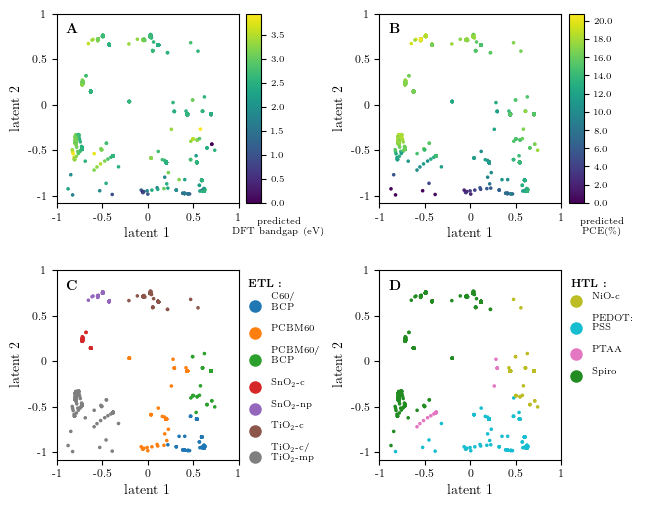

 --> Saved 2D latent plot to model directory
 --> Exit.


<Figure size 640x480 with 0 Axes>

In [3]:
##### USER INPUT GOES HERE #####

run_dir = '../../runs/perovskite_multiscale_dataset_3'
device_dataset_filepath = '../../datasets/PSC_efficiencies/PSC_efficiencies_dataset.csv'
bg_preds_filepath = '../../runs/perovskite_multiscale_dataset_3/ae1_bg_predictor_enc_l_12_l1_1em2_tanh_pred_p_0_1_100_relu_dec_15_linear_seed_0_lr_1em3_bs_10_1500_epochs_mae_mtl_k_fold_0_xavier_normal/submodule_outputs/predict/bg_pred_output.csv'
model_type = 'ae2_PCE_predictor_enc_l_2_l1_1em2_tanh_predictor_0_1_100_relu_decoder_linear_seed_0_lr_1em3_bs_100_e_1500_pass_latents_ae1_fold_0_ae2_fold_2_xavier_normal_gain_10'

true_bg_lower_lim = 1.2
true_bg_upper_lim = 1.8

# ETM types and corresponding colors
etm_classes = ['C60/BCP', 'PCBM60', 'PCBM60/BCP', r'SnO_{2}-c', r'SnO_{2}-np', r'TiO_{2}-c', r'TiO_{2}-c/TiO_{2}-mp']
etm_classes_enc = [0, 1, 2, 3, 4, 5, 6, 7]
etm_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:grey']

# HTM types and corresponding colors
htm_classes = ['NiO-c\n', 'PEDOT:\nPSS\n', 'PTAA\n', 'Spiro\n']
htm_classes_enc = [0, 1, 2, 3, 4]
htm_colors = ['tab:olive', 'tab:cyan', 'tab:pink', 'forestgreen']

################################

# Enter fontsize for y axis labels and annotations

figsize = (7.5, 10)

fontsize_labels = 10
fontsize_ticks = 8
fontsize_cbar = 6.5

# Font style
plt.rcParams.update({
"text.usetex":True,
"font.family":"serif",
"font.serif":["Computer Modern Roman"]})

s = 10
alpha = 1
marker = 'o'

colorscale = 'viridis'
cax = True

################################

#############################################################################################
# Extract the true bandgaps, pce, ETM, HTM types from the perovskite device dataset
#############################################################################################

print(os.getcwd())

# Read the dataset 
PSC_efficiencies_dataset = pd.read_csv(device_dataset_filepath, header=0)

# Get the bandgap values which are not NA
true_bg = PSC_efficiencies_dataset['Perovskite_band_gap'][PSC_efficiencies_dataset['Perovskite_band_gap'].notna()]
non_nan_bg_idxs = PSC_efficiencies_dataset['Perovskite_band_gap'][PSC_efficiencies_dataset['Perovskite_band_gap'].notna()].index.tolist()

# Among the non nan bandgap entries, get the indices of those that lie within the specified range
idxs_within_bg_range = [i for i in non_nan_bg_idxs if true_bg_lower_lim <= true_bg[i] <= true_bg_upper_lim]
true_bg = true_bg[idxs_within_bg_range]

assert len(true_bg) == len(idxs_within_bg_range)

# Get the true pce, etm and htm types for the select bandgaps
true_pce = PSC_efficiencies_dataset['JV_reverse_scan_PCE'].iloc[idxs_within_bg_range]
true_etm = PSC_efficiencies_dataset['ETL_stack_sequence'].iloc[idxs_within_bg_range]
true_htm = PSC_efficiencies_dataset['HTL_stack_sequence'].iloc[idxs_within_bg_range]

unique_etm = np.unique(true_etm)
unique_htm = np.unique(true_htm)

assert len(true_bg) == len(true_pce) == len(true_etm) == len(true_htm)

##################################################################################################################################
# Extract the NestedAE predicted bandgaps, pce, ETM, HTM types from the model for which latent space is being generated
##################################################################################################################################

# Get ML predicted DFT bandgaps for the compisitions with true bg values
pred_bg = pd.read_csv(bg_preds_filepath, header=None).iloc[idxs_within_bg_range].to_numpy().squeeze()

min_bg = np.min(pred_bg)
max_bg = np.max(pred_bg)

nn_save_dir = run_dir + '/' + model_type

# Get the ML predicted pce values for the compisitions with true bg values
pce_pred_filepath = nn_save_dir + '/submodule_outputs/train/PCE_pred_output_on_fit_end.csv'
pred_pce = pd.read_csv(pce_pred_filepath, header=None).iloc[idxs_within_bg_range].to_numpy().squeeze()

min_pce = np.min(pred_pce)
max_pce = np.max(pred_pce)

# Get the ML predicted etm types for the compisitions with true bg values
etm_pred_filepath = nn_save_dir + '/submodule_outputs/train/etm_pred_output_on_fit_end.csv'

# ETM predictions
etm_pred_filepath = nn_save_dir + '/submodule_outputs/train/etm_pred_output_on_fit_end.csv'
pred_etm = pd.read_csv(etm_pred_filepath, header=None).iloc[idxs_within_bg_range].to_numpy().squeeze()
print(' --> Loaded ETM predictions from csv.')

pred_etm_exp = np.exp(pred_etm)
pred_etm_exp_sum = np.sum(pred_etm_exp, axis=1)

# Divide each element in row of preds_etm_exp by entry in preds_etm_exp_sum
pred_etm_p = pred_etm_exp/pred_etm_exp_sum[:,None]

# Now find index of maximum value in each row of preds_etm_p and use that as the color
c_etm = np.argmax(pred_etm_p, axis=1)
cmin_etm = np.min(c_etm)
cmax_etm = np.max(c_etm)

# HTM predictions
htm_pred_filepath = nn_save_dir + '/submodule_outputs/train/htm_pred_output_on_fit_end.csv'
pred_htm = pd.read_csv(htm_pred_filepath, header=None).iloc[idxs_within_bg_range].to_numpy().squeeze()
print(' --> Loaded HTM predictions from csv.')

pred_htm_exp = np.exp(pred_htm)
pred_htm_exp_sum = np.sum(pred_htm_exp, axis=1)

# Divide each element in row of preds_etm_exp by entry in preds_etm_exp_sum
pred_htm_p = pred_htm_exp/pred_htm_exp_sum[:,None]

# Now find index of maximum value in each row of preds_etm_p and use that as the color
c_htm = np.argmax(pred_htm_p, axis=1)
cmin_htm = np.min(c_htm)
cmax_htm = np.max(c_htm)

# Load the latents
latent_filepath = nn_save_dir + '/submodule_outputs/train/encoder_output_on_fit_end.csv'
skip_header = 0
latents = pd.read_csv(latent_filepath, header=None).iloc[idxs_within_bg_range].to_numpy().squeeze()
print(' --> Loaded latents from csv.')
    
plots_dir = nn_save_dir + '/plots'
if not os.path.exists(plots_dir):
    os.mkdir(plots_dir)
    
figure_dir = plots_dir + '/NestedAE_2D_latent_space_colored_by_predictions'
if not os.path.exists(figure_dir):
    os.mkdir(figure_dir)

tick_labels = [-1, -0.5,  0, 0.5, 1]

fig = plt.figure(figsize=figsize)
gs = mpl.gridspec.GridSpec(3, 6, height_ratios=[1, 1, 1], width_ratios=[1, 1, 0.2, 1, 1, 0.2], wspace=1.5, hspace=0)

# Subfigure 1. Color latents wrt predicted DFT BG
ax1 = fig.add_subplot(gs[0, 0:2])
latents_2D_data_1 = ax1.scatter(latents[:,0], latents[:,1], marker='.', c=pred_bg, s=s, alpha=alpha)
ax1.set_xlabel('latent 1')
ax1.set_ylabel('latent 2')
ax1.set_xticks(tick_labels)
ax1.set_xticklabels(tick_labels)
ax1.set_yticks(tick_labels)
ax1.set_yticklabels(tick_labels)
ax1.tick_params(axis='y', labelsize=fontsize_ticks)
ax1.tick_params(axis='x', labelsize=fontsize_ticks)
ax1.set_aspect('equal')
#ax1.set_ylim([-1.2,1.2])
#ax1.set_xlim([-1.2,1.2])

ax1.text(0.05, 0.95, r'\textbf{A}', transform=ax1.transAxes, fontsize=fontsize_labels, verticalalignment='top')

cbar1 = fig.colorbar(latents_2D_data_1, cax=fig.add_subplot(gs[0, 2]), orientation='vertical')
cbar1_ticks = np.arange(min_bg, max_bg, 0.5)
cbar1.ax.set_xlabel('predicted\n DFT bandgap (eV)', fontsize=fontsize_cbar)
cbar1.ax.xaxis.set_label_coords(2.2, -0.08)
cbar1.ax.set_yticks(cbar1_ticks)
cbar1.ax.set_yticklabels(cbar1_ticks)
cbar1.ax.tick_params(labelsize=fontsize_cbar)
cbar1.ax.set_position([ax1.get_position().x1 + 0.01, ax1.get_position().y0, 0.02, ax1.get_position().height])

# Subfigure 2. Color latents wrt predicted PCE
ax2 = fig.add_subplot(gs[0, 3:5])
latents_2D_data_2 = ax2.scatter(latents[:,0], latents[:,1], marker='.', c=pred_pce, s=s, alpha=alpha)
ax2.set_xlabel('latent 1')
ax2.set_ylabel('latent 2')
ax2.set_xticks(tick_labels)
ax2.set_xticklabels(tick_labels)
ax2.set_yticks(tick_labels)
ax2.set_yticklabels(tick_labels)
ax2.tick_params(axis='y', labelsize=fontsize_ticks)
ax2.tick_params(axis='x', labelsize=fontsize_ticks)
ax2.set_aspect('equal')

ax2.text(0.05, 0.95, r'\textbf{B}', transform=ax2.transAxes, fontsize=fontsize_labels, verticalalignment='top')

cbar2 = fig.colorbar(latents_2D_data_2, cax=fig.add_subplot(gs[0, 5]), orientation='vertical')
cbar2_ticks = np.arange(min_pce, max_pce, 2)
cbar2.ax.set_xlabel('predicted\nPCE' + r'(\%)', fontsize=fontsize_cbar)
cbar2.ax.xaxis.set_label_coords(2.2, -0.08)
cbar2.ax.set_yticks(cbar2_ticks)
cbar2.ax.set_yticklabels(cbar2_ticks)
cbar2.ax.tick_params(labelsize=fontsize_cbar)
cbar2.ax.set_position([ax2.get_position().x1 + 0.01, ax2.get_position().y0, 0.02, ax2.get_position().height])

# Color legend for ETM and HTM types
etm_legend_elements = [Line2D([0], [0], marker='o', color=etm_colors[0], label='C60'+'/\n'+'BCP\n', linestyle='None',
                                markerfacecolor=etm_colors[0], markersize=8),

                       Line2D([0], [0], marker='o', color=etm_colors[1], label='PCBM60\n', linestyle='None',
                                markerfacecolor=etm_colors[1], markersize=8),

                       Line2D([0], [0], marker='o', color=etm_colors[2], label='PCBM60'+'/\n'+'BCP\n', linestyle='None',
                                markerfacecolor=etm_colors[2], markersize=8),

                       Line2D([0], [0], marker='o', color=etm_colors[3], label=r'SnO$_{2}$-c'+'\n', linestyle='None',
                                markerfacecolor=etm_colors[3], markersize=8),

                       Line2D([0], [0], marker='o', color=etm_colors[4], label=r'SnO$_{2}$-np'+'\n', linestyle='None',
                                markerfacecolor=etm_colors[4], markersize=8),

                       Line2D([0], [0], marker='o', color=etm_colors[5], label=r'TiO$_{2}$-c'+'\n', linestyle='None',
                                markerfacecolor=etm_colors[5], markersize=8),

                       Line2D([0], [0], marker='o', color=etm_colors[6], label=r'TiO$_{2}$-c'+'/\n'+r'TiO$_{2}$-mp'+'\n', linestyle='None',
                                markerfacecolor=etm_colors[6], markersize=8),
                                
                                ]

htm_legend_elements = [Line2D([0], [0], marker='o', color=htm_colors[0], label=htm_classes[0], linestyle='None',
                                markerfacecolor=htm_colors[0], markersize=8),

                       Line2D([0], [0], marker='o', color=htm_colors[1], label=htm_classes[1], linestyle='None',
                                markerfacecolor=htm_colors[1], markersize=8),

                       Line2D([0], [0], marker='o', color=htm_colors[2], label=htm_classes[2], linestyle='None',
                                markerfacecolor=htm_colors[2], markersize=8),

                       Line2D([0], [0], marker='o', color=htm_colors[3], label=htm_classes[3], linestyle='None',
                                markerfacecolor=htm_colors[3], markersize=8)]

cmap_etm = ListedColormap(etm_colors)
# Boaundary norm for etm
norm_etm = BoundaryNorm(etm_classes_enc, cmap_etm.N)

# Subfigure 3. Color latents based on predicted ETM
ax3 = fig.add_subplot(gs[1, 0:2])
latents_2D_data_3 = ax3.scatter(latents[:,0], latents[:,1], marker='.', c=c_etm, cmap=cmap_etm, norm=norm_etm, s=s, alpha=alpha)
ax3.set_xlabel('latent 1')
ax3.set_ylabel('latent 2')
ax3.set_xticks(tick_labels)
ax3.set_xticklabels(tick_labels)
ax3.set_yticks(tick_labels)
ax3.set_yticklabels(tick_labels)
ax3.tick_params(axis='y', labelsize=fontsize_ticks)
ax3.tick_params(axis='x', labelsize=fontsize_ticks)
ax3.set_aspect('equal')
ax3.text(0.05, 0.95, r'\textbf{C}', transform=ax3.transAxes, fontsize=fontsize_labels, verticalalignment='top')
ax3.text(1.05, 0.95, r'\textbf{ETL :}', transform=ax3.transAxes, fontsize=fontsize_cbar+1, verticalalignment='top')
ax3.legend(handles=etm_legend_elements, loc='upper right', bbox_to_anchor=(1.47, 0.9), borderaxespad=0, fontsize=fontsize_cbar, frameon=False)

cmap_htm = ListedColormap(htm_colors)
# Boaundary norm for etm
norm_htm = BoundaryNorm(htm_classes_enc, cmap_htm.N)

# Subfigure 4. Color latents based on predicted HTM
ax4 = fig.add_subplot(gs[1, 3:5])
latents_2D_data_4 = ax4.scatter(latents[:,0], latents[:,1], marker='.', c=c_htm, cmap=cmap_htm, norm=norm_htm, s=s, alpha=alpha)
ax4.set_xlabel('latent 1')
ax4.set_ylabel('latent 2')
ax4.set_xticks(tick_labels)
ax4.set_xticklabels(tick_labels)
ax4.set_yticks(tick_labels)
ax4.set_yticklabels(tick_labels)
ax4.tick_params(axis='y', labelsize=fontsize_ticks)
ax4.tick_params(axis='x', labelsize=fontsize_ticks)
ax4.set_aspect('equal')
ax4.text(0.05, 0.95, r'\textbf{D}', transform=ax4.transAxes, fontsize=fontsize_labels, verticalalignment='top')
ax4.text(1.05, 0.95, r'\textbf{HTL :}', transform=ax4.transAxes, fontsize=fontsize_cbar+1, verticalalignment='top')
ax4.legend(handles=htm_legend_elements, loc='upper right', bbox_to_anchor=(1.42, 0.9), borderaxespad=0, fontsize=fontsize_cbar, frameon=False)

# Set equal aspect ration for 2D latent plot
#plt.tight_layout()
plt.savefig('latents_2D_colored_by_pred_PCE_bg_etm_htm.pdf', dpi=400)
plt.show()
plt.clf()

print(' --> Saved 2D latent plot to model directory')
print(' --> Exit.')


### (1) Predicted bandgap vs Predicted PCE colored based on predicted ETL and HTL and (2) True bandgap vs True PCE colored based on true ETL and HTl contacts in dataset

/var/folders/k2/lw7ggcln7zx_cnkbk2zbgvm80000gn/T/ipykernel_14683/3437717761.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


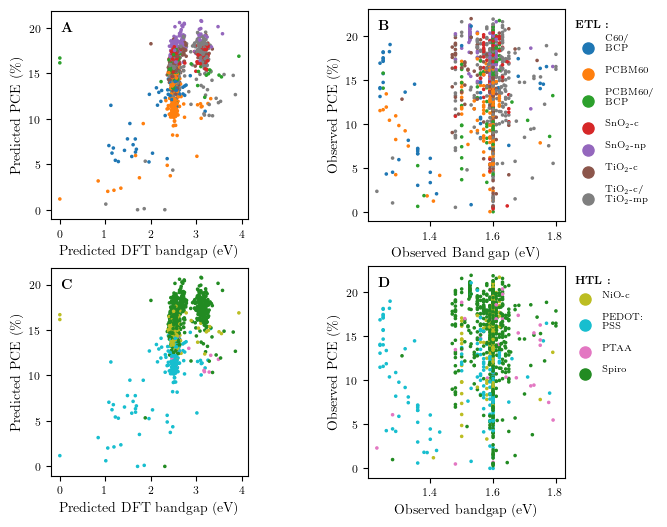

<Figure size 640x480 with 0 Axes>

In [4]:
fig = plt.figure(figsize=figsize)
gs = mpl.gridspec.GridSpec(3, 6, height_ratios=[1, 1, 1], width_ratios=[1, 1, 0.2, 1, 1, 0.2], wspace=1, hspace=0)

# Subfigure 1. Create predicted bandgap vs predicted PCE plot and color based on true etm
true_etm = true_etm.replace(unique_etm, etm_classes_enc[:-1]).tolist()

ax5 = fig.add_subplot(gs[0, 0:2])
data_1 = ax5.scatter(pred_bg, pred_pce, marker='.', c=c_etm, cmap=cmap_etm, norm=norm_etm, s=s, alpha=alpha)
ax5.set_xlabel(r'Predicted DFT bandgap (eV)', fontsize=fontsize_labels)
ax5.set_ylabel(r'Predicted PCE (\%)', fontsize=fontsize_labels)
ax5.tick_params(axis='y', labelsize=fontsize_ticks)
ax5.tick_params(axis='x', labelsize=fontsize_ticks)
#ax5.set_xlim(left=true_bg_lower_lim-0.05, right=true_bg_upper_lim+0.05)
#ax5.set_ylim(bottom=0)
ax5.set_aspect(0.2)
ax5.text(0.05, 0.95, r'\textbf{A}', transform=ax5.transAxes, fontsize=fontsize_labels, verticalalignment='top')

# Subfigure 2. Create true bandgap vs true PCE plot and color based on true etm
ax6 = fig.add_subplot(gs[0, 3:5])
data_1 = ax6.scatter(true_bg, true_pce, marker='.', c=true_etm, cmap=cmap_etm, norm=norm_etm, s=s, alpha=alpha)
ax6.set_xlabel(r'Observed Band gap (eV)', fontsize=fontsize_labels)
ax6.set_ylabel(r'Observed PCE (\%)', fontsize=fontsize_labels)
ax6.tick_params(axis='y', labelsize=fontsize_ticks)
ax6.tick_params(axis='x', labelsize=fontsize_ticks)
#ax6.set_xlim(left=true_bg_lower_lim-0.05, right=true_bg_upper_lim+0.05)
#ax6.set_ylim(bottom=0)
ax6.set_aspect(0.028)
ax6.legend(handles=etm_legend_elements, loc='upper right', bbox_to_anchor=(1.47, 0.9), borderaxespad=0, fontsize=fontsize_cbar, frameon=False)
ax6.text(0.05, 0.95, r'\textbf{B}', transform=ax6.transAxes, fontsize=fontsize_labels, verticalalignment='top')
ax6.text(1.05, 0.95, r'\textbf{ETL :}', transform=ax6.transAxes, fontsize=fontsize_cbar+1, verticalalignment='top')

# Subfigure 3. Create true bandgap vs true PCE plot and color based on true htm
true_htm = true_htm.replace(unique_htm, htm_classes_enc[:-1]).tolist()

ax7 = fig.add_subplot(gs[1, 0:2])
data_2 = ax7.scatter(pred_bg, pred_pce, marker='.', c=c_htm, cmap=cmap_htm, norm=norm_htm, s=s, alpha=alpha)
ax7.set_xlabel(r'Predicted DFT bandgap (eV)', fontsize=fontsize_labels)
ax7.set_ylabel(r'Predicted PCE (\%)', fontsize=fontsize_labels)
ax7.tick_params(axis='y', labelsize=fontsize_ticks)
ax7.tick_params(axis='x', labelsize=fontsize_ticks)
#ax7.set_xlim(left=true_bg_lower_lim-0.05, right=true_bg_upper_lim+0.05)
#ax7.set_ylim(bottom=0)
ax7.set_aspect(0.2)
ax7.text(0.05, 0.95, r'\textbf{C}', transform=ax7.transAxes, fontsize=fontsize_labels, verticalalignment='top')

# Subfigure 4. Create true bandgap vs true PCE plot and color based on true htm
ax8 = fig.add_subplot(gs[1, 3:5])
data_2 = ax8.scatter(true_bg, true_pce, marker='.', c=true_htm, cmap=cmap_htm, norm=norm_htm, s=s, alpha=alpha)
ax8.set_xlabel(r'Observed bandgap (eV)', fontsize=fontsize_labels)
ax8.set_ylabel(r'Observed PCE (\%)', fontsize=fontsize_labels)
ax8.tick_params(axis='y', labelsize=fontsize_ticks)
ax8.tick_params(axis='x', labelsize=fontsize_ticks)
#ax8.set_xlim(left=true_bg_lower_lim-0.05, right=true_bg_upper_lim+0.05)
#ax8.set_ylim(bottom=0)
ax8.set_aspect(0.028)
ax8.legend(handles=htm_legend_elements, loc='upper right', bbox_to_anchor=(1.42, 0.9), borderaxespad=0, fontsize=fontsize_cbar, frameon=False)
ax8.text(0.05, 0.95, r'\textbf{D}', transform=ax8.transAxes, fontsize=fontsize_labels, verticalalignment='top')
ax8.text(1.05, 0.95, r'\textbf{HTL :}', transform=ax8.transAxes, fontsize=fontsize_cbar+1, verticalalignment='top')

# Set equal aspect ration for 2D latent plot
plt.tight_layout()
plt.savefig('pred_bg_vs_pred_pce_colored_by_pred_etm_and_htm_true_bg_vs_true_pce_colored_by_true_etm_and_htm.pdf', dpi=400)
plt.show()
plt.clf()

### Violin plots of predictions across 5 folds

In [ ]:
foldnum = np.arange(0, 5, 1)

train_bg_data_mae = [0.157977541, 0.154160118, 0.165781746, 0.153398661, 0.148404311]
val_bg_data_mae = [0.14217873, 0.201541364, 0.146679723, 0.157143428, 0.192410904]
train_pce_data_mae = [2.573488376, 2.538863568, 2.541464946, 2.57149054, 2.60226829]
val_pce_data_mae = [2.333340263, 2.419425416, 2.409774113, 2.38371649, 2.37378478]

all_data = [train_bg_data_mae, val_bg_data_mae, train_pce_data_mae, val_pce_data_mae]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
# Create the violin plot
axs[0].violinplot(all_data[0:2], showmedians=True)
axs[0].set_xticks([1, 2])
axs[0].set_xticklabels(['Train', 'Validation'])
axs[0].set_ylabel('Bandgap MAE (eV)')

axs[1].violinplot(all_data[2:4], showmedians=True)
axs[1].set_xticks([1, 2])
axs[1].set_xticklabels(['Train', 'Validation'])
axs[1].set_ylabel('PCE MAE (/%)')

# Show the plot
plt.show()


### Plotting cross-validated predictions

In [ ]:
################################

figsize = (7.5, 4)

# Enter fontsize for y axis labels and annotations
fontsize_labels = 10
fontsize_ticks = 8

# Font style
plt.rcParams.update({
"text.usetex":True,
"font.family":"serif",
"font.serif":["Computer Modern Roman"]})

s = 1
alpha = 1

################################

# Get the predictions from each fold and store in a list
bg_pred_list = []
bg_true_list = []
pce_pred_list = []
pce_true_list = []

# Get the true and predicted values for bandgap (plotted are all validation data from each of teh 5 folds)
for i in range(5):
    bg_preds_filepath = f'../runs/perovskite_multiscale_dataset_3/ae1_bg_predictor_enc_l_12_l1_1em2_tanh_pred_p_0_1_100_relu_dec_15_linear_seed_0_lr_1em3_bs_10_1500_epochs_mae_mtl_k_fold_{i}_xavier_normal/submodule_outputs/predict_for_ae1/bg_pred_output.csv'
    bg_true_filepath = f'../runs/perovskite_multiscale_dataset_3/ae1_bg_predictor_enc_l_12_l1_1em2_tanh_pred_p_0_1_100_relu_dec_15_linear_seed_0_lr_1em3_bs_10_1500_epochs_mae_mtl_k_fold_{i}_xavier_normal/datasets/val_dataset_preview_fold_{i}.csv'

    bg_preds = list(load_csv_file(bg_preds_filepath, skip_header=0))
    bg_true = load_csv_file(bg_true_filepath, skip_header=1)[:, 16]

    bg_pred_list.extend(bg_preds)
    bg_true_list.extend(bg_true)

# Get the true and predicted values for PCE (plotted are all validation data from each of teh 5 folds)
for i in range(5):
    pce_preds_filepath = f'../runs/perovskite_multiscale_dataset_3/ae2_PCE_predictor_enc_l_18_l1_1em2_tanh_predictor_0_1_100_relu_decoder_linear_seed_0_lr_1em3_bs_100_e_1500_pass_latents_ae1_fold_0_ae2_fold_{i}_xavier_normal_gain_10/submodule_outputs/predict/PCE_pred_output.csv'
    pce_true_filepath = f'../runs/perovskite_multiscale_dataset_3/ae2_PCE_predictor_enc_l_18_l1_1em2_tanh_predictor_0_1_100_relu_decoder_linear_seed_0_lr_1em3_bs_100_e_1500_pass_latents_ae1_fold_0_ae2_fold_{i}_xavier_normal_gain_10/datasets/val_dataset_preview_fold_{i}.csv'

    pce_preds = list(load_csv_file(pce_preds_filepath, skip_header=0))
    pce_true = load_csv_file(pce_true_filepath, skip_header=1)[:, 26]

    pce_pred_list.extend(pce_preds)
    pce_true_list.extend(pce_true)

print(len(bg_pred_list))
print(len(bg_true_list))
print(len(pce_pred_list))
print(len(pce_true_list))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7.5, 4))

x1 = np.arange(-1, np.max(bg_true_list)+1, 1)
y1 = np.arange(-1, np.max(bg_true_list)+1, 1)

x2 = np.arange(-1, np.max(pce_true_list)+1, 1)
y2 = np.arange(-1, np.max(pce_true_list)+1, 1)

axs[0].scatter(bg_true_list, bg_pred_list, s=s, alpha=alpha)
axs[0].plot(x1, y1, color='black', linestyle='-', linewidth=1)
axs[0].set_xlabel('True DFT Bandgap (eV)', fontsize=fontsize_labels)
axs[0].set_ylabel('Predicted DFT Bandgap (eV)', fontsize=fontsize_labels)
axs[0].set_xlim(-0.5, np.max(bg_true_list)+0.5)
axs[0].set_ylim(-0.5, np.max(bg_true_list)+0.5)

axs[0].tick_params(axis='y', labelsize=fontsize_ticks)
axs[0].tick_params(axis='x', labelsize=fontsize_ticks)
axs[0].set_aspect('equal')

axs[0].text(0.05, 0.95, r'\textbf{A}', transform=axs[0].transAxes, fontsize=fontsize_labels, verticalalignment='top')
axs[0].text(0.47, 0.1, 'Val. MAE = 0.168 eV', transform=axs[0].transAxes, fontsize=fontsize_labels, verticalalignment='bottom', color='red')
axs[0].text(0.45, 0.02, 'Val. RMSE = 0.230 eV', transform=axs[0].transAxes, fontsize=fontsize_labels, verticalalignment='bottom', color='red')
#axs[0].text(0.95, 0.0, , transform=axs[0].transAxes, fontsize=fontsize_labels, verticalalignment='bottom')

axs[1].scatter(pce_true_list, pce_pred_list, s=s, alpha=alpha)
axs[1].plot(x2, y2, color='black', linestyle='-', linewidth=1)
axs[1].set_xlabel(r'True PCE (\%)', fontsize=fontsize_labels)
axs[1].set_ylabel(r'Predicted PCE (\%)', fontsize=fontsize_labels)
axs[1].set_xlim(-0.5, np.max(pce_true_list)+0.5)
axs[1].set_ylim(-0.5, np.max(pce_true_list)+0.5)

axs[1].tick_params(axis='y', labelsize=fontsize_ticks)
axs[1].tick_params(axis='x', labelsize=fontsize_ticks)
axs[1].set_aspect('equal')

axs[1].text(1.25, 0.95, r'\textbf{B}', transform=axs[0].transAxes, fontsize=fontsize_labels, verticalalignment='top')
axs[1].text(1.69, 0.1, r'Val. MAE = 2.384 \%', transform=axs[0].transAxes, fontsize=fontsize_labels, verticalalignment='bottom', color='red')
axs[1].text(1.67, 0.02, r'Val. RMSE = 3.240 \%', transform=axs[0].transAxes, fontsize=fontsize_labels, verticalalignment='bottom', color='red')

plt.savefig('./parity_plots.pdf', dpi=400)
plt.show()
plt.clf()

### Mean Absolute Error plots for Smooth and Noisy functions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Tick parameters
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 15

funcaddnoise_ae1 = [0.42,0.41,0.43,0.42,0.42,0.41,0.41,0.41,0.41,0.42]
funcaddnoise_ae2 = [0.48,0.44,0.49,0.49,0.5,0.45,0.50,0.50,0.46,0.47]
funcaddnoise = [0.5*sum(x) for x in zip(funcaddnoise_ae1,funcaddnoise_ae2)] 
funcaddnoise_single = [0.5,0.47,0.46,0.51,0.52,0.50,0.50,0.54,0.52,0.49]

funcaddnoise_ae1_val = [0.40,0.43,0.43,0.42,0.40,0.43,0.44,0.45,0.42,0.42]
funcaddnoise_ae2_val = [0.49,0.47,0.57,0.47,0.45,0.45,0.54,0.46,0.49,0.52]
funcaddnoise_val = [0.5*sum(x) for x in zip(funcaddnoise_ae1_val,funcaddnoise_ae2_val)] 
funcaddnoise_single_val = [0.52,0.49,0.54,0.51,0.49,0.54,0.56,0.53,0.56,0.54]

nestedF_ae1 = [0.21,0.20,0.22,0.21,0.20,0.21,0.21,0.23,0.18,0.17]
nestedF_ae2 = [0.26,0.22,0.25,0.27,0.26,0.23,0.24,0.23,0.19,0.22]
nestedF = [0.5*sum(x) for x in zip(nestedF_ae1,nestedF_ae2)] 
nestedF_single = [0.3,0.3,0.23,0.3,0.26,0.23,0.26,0.30,0.27,0.26]

nestedF_ae1_val = [0.26,0.23,0.18,0.14,0.16,0.19,0.23,0.25,0.21,0.21]
nestedF_ae2_val = [0.27,0.24,0.21,0.21,0.24,0.22,0.24,0.24,0.25,0.26]
nestedF_val = [0.5*sum(x) for x in zip(nestedF_ae1_val,nestedF_ae2_val)] 
nestedF_single_val = [0.31,0.31,0.27,0.27,0.21,0.20,0.30,0.29,0.29,0.30]

iter_to_reach_max_ana = [ nestedF_single, nestedF_single_val, nestedF, nestedF_val]  

iter_to_reach_max_noisy = [funcaddnoise_single, funcaddnoise_single_val, funcaddnoise, funcaddnoise_val]  

# Create a figure and axis
fig, ax = plt.subplots()

# Create vertical violin plots with whiskers at 95% confidence intervals
violin_parts = ax.violinplot(iter_to_reach_max_ana, vert=True, showmedians=True)
violin_parts = ax.violinplot(iter_to_reach_max_noisy, vert=True, showmedians=True)

# Calculate and plot whiskers at 95% confidence interval for each list
def plot_whiskers(data, position, color):
    whisker_low = np.percentile(data, 5)
    whisker_high = np.percentile(data, 95)
    ax.vlines(position, whisker_low, whisker_high, color=color, linewidth=2)

for i, data in enumerate(iter_to_reach_max_ana):
    plot_whiskers(data, i + 1, 'blue')

for i, data in enumerate(iter_to_reach_max_noisy):
    plot_whiskers(data, i + 1, 'red')

method_list= ['Train \n Single AE', 'Test \n Single AE', 'Train \n NestedAE', 'Test \n NestedAE']
# Set x-axis ticks and labels
ax.set_xticks(np.arange(1, 5))
ax.set_xticklabels(method_list,size=15)
ax.set_ylim([None, 0.63])

# Create a custom legend using proxy artists
legend_elements = [
    Patch(facecolor='blue', edgecolor='blue', label='Smooth functions'),
    Patch(facecolor='orange', edgecolor='orange', label='Noisy functions')
]
ax.legend(handles=legend_elements, loc='upper right')

# Set labels and title
ax.set_xlabel('')
ax.set_ylabel('Mean Absolute Error',size=15)

plt.tight_layout()
#plt.savefig('/Users/maitreyeesharma/WORKSPACE/Publications/2023/q46/figs/synthetic_dataset/syntheticD_performance.pdf', bbox_inches='tight')